In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data_links_biarcs0 = ['https://dspass3ngrams.s3.amazonaws.com/csv/output_dpmin4.csv',
  'https://dspass3ngrams.s3.amazonaws.com/csv/output_dpmin5.csv',
  'https://dspass3ngrams.s3.amazonaws.com/csv/output_dpmin6.csv'] 

data_links_biarcs1 = ['https://dspass3ngrams.s3.amazonaws.com/csv/output2_dpmin6.csv.zip',
                      'https://dspass3ngrams.s3.amazonaws.com/csv/output2_dpmin5.csv.zip',
                      'https://dspass3ngrams.s3.amazonaws.com/csv/output2_dpmin4.csv.zip']

data_links = data_links_biarcs1


In [3]:
# !wget https://dspass3ngrams.s3.amazonaws.com/csv/output2_dpmin6.csv.zip
!wget https://dspass3ngrams.s3.amazonaws.com/csv/output2_dpmin5.csv.zip
# !wget https://dspass3ngrams.s3.amazonaws.com/csv/output2_dpmin4.csv.zip

#TODO: generify this

--2020-08-21 15:21:32--  https://dspass3ngrams.s3.amazonaws.com/csv/output2_dpmin5.csv.zip
Resolving dspass3ngrams.s3.amazonaws.com (dspass3ngrams.s3.amazonaws.com)... 54.231.73.35
Connecting to dspass3ngrams.s3.amazonaws.com (dspass3ngrams.s3.amazonaws.com)|54.231.73.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4443988 (4.2M) [application/zip]
Saving to: ‘output2_dpmin5.csv.zip’

output2_dpmin5.csv. 100%[===================>]   4.24M  3.15MB/s    in 1.3s    

2020-08-21 15:21:34 (3.15 MB/s) - ‘output2_dpmin5.csv.zip’ saved [4443988/4443988]



In [4]:
!unzip \*.zip

!ls

Archive:  output2_dpmin5.csv.zip
  inflating: output2_dpmin5.csv      
DSP3_Classification.ipynb       output2_dpmin5.csv
DSP3_Classification_final.ipynb output2_dpmin5.csv.zip


In [5]:
# _df = pd.read_csv ('output2_dpmin{0}.csv'.format(4))
# print(df.head())

In [6]:
# words[4]['Word1']

We run this with 3 _DPMIN_ Values: ${4,5,6}$

In [7]:
checks = [5]


In [8]:
X = {}
Y = {}
words = {}
embd_X = {}

for i in checks:

  df = pd.read_csv ('output2_dpmin{0}.csv'.format(i))
  feature_len = len(df.columns)-3 #3 because we don't care about: Word1, Word2 and True Label

  X_df = df[['Feature_'+str(j)  for j in range (feature_len)]]
  Y_df = df[['True Label']]
  words[i] = df[['Word1','Word2']]

  X[i] = np.squeeze(X_df.to_numpy())
  Y[i] = np.squeeze(Y_df.to_numpy())

## Machine Learning


### Preprocessing

In [9]:
from sklearn.decomposition import PCA

K = 100 # the new dimesnion size - we reducing to

for i in checks:

  pca = PCA(n_components = K)
  embd_X[i] = pca.fit_transform(X[i])
  total_var = pca.explained_variance_ratio_.cumsum()[-1]
  print('Total variance retrained with this PCA: {0}%'.format(total_var*100))

Total variance retrained with this PCA: 70.63776013733136%


Then, we will visualize the datapoints

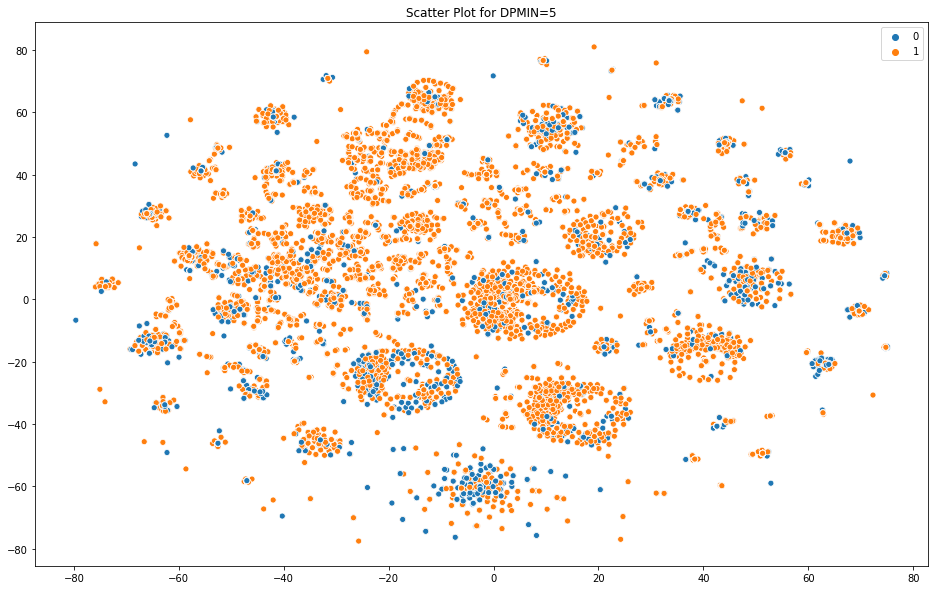

In [10]:
from sklearn.manifold import TSNE

for i in checks:

  np.random.seed(33)
  tsne = TSNE(n_components=2).fit_transform(embd_X[i]) #TSNE is good for visualising scatter plots
  plt.figure(figsize=(16,10))
  sns.scatterplot(tsne[:,0],tsne[:,1],hue=Y[i])
  plt.title('Scatter Plot for DPMIN={}'.format(i))

Doesn't seem like it can be easily seperated, at least with no kernel.

### Training

We will train with logistic regression and with $CV = 10$

In [11]:
clf_logic = {}
for i in checks:
  tmp_clf = LogisticRegressionCV(cv = 10,class_weight='balanced',max_iter=10_000).fit(embd_X[i],Y[i])
  print('i-th score: ', tmp_clf.score(embd_X[i],Y[i]))
  clf_logic[i] = tmp_clf

i-th score:  0.6454076850984067


### Analysis

In [12]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score

def analyse_clf (clf,i):
  
  y_pred = np.round(clf.predict(embd_X[i]))
  y_true = Y[i]

  prf =  list(precision_recall_fscore_support( y_true, y_pred,average='binary'))[:-1]
  prf.append(roc_auc_score(y_true,y_pred))
  conf_mat = confusion_matrix(y_true, y_pred,normalize='true') #also normlize according to the truth
  

  print('Precision: {0}\nRecall: {1}\nF1_Score:{2}\n ROC: {3}'.format(*prf))
  print('-------------------------------------')
  plt.figure()
  sns.heatmap(conf_mat,annot=True)
  # row is true, column is predicted


Precision: 0.8678224101479916
Recall: 0.6308865117422845
F1_Score:0.7306254672314976
 ROC: 0.6614227592215561
-------------------------------------


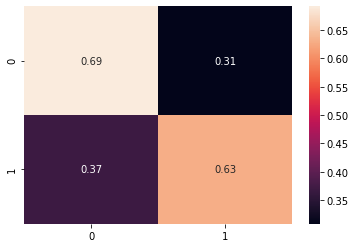

In [13]:
for i in checks:
  analyse_clf(clf_logic[i],i)

Now let us try [$SVC$](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

***********5**********
Precision: 0.7722720335749714
Recall: 0.9955121111520964
F1_Score:0.869796422624483
 ROC: 0.5272199893561034
-------------------------------------


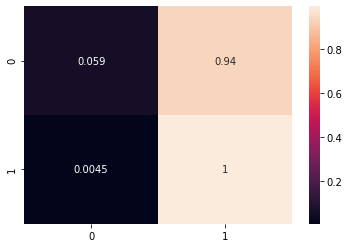

In [14]:
scoring = ['precision', 'recall','accuracy','f1','roc_auc']
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

best_models = {}

for i in checks:

  tmp_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  # tmp_clf.fit(embd_X[i],Y[i])
  
  scores = cross_validate(tmp_clf, embd_X[i], Y[i], scoring=scoring,return_estimator=True,cv=10)
  print("***********{}**********".format(i))
  # print(scores)

  best_model_ndx = np.argmax(scores['test_roc_auc'])
  print
  best_models[i] = scores['estimator'][best_model_ndx]

  analyse_clf(best_models[i],i)


Let us try with _balanced_ class weight

***********5**********
Precision: 0.8747974068071313
Recall: 0.6636542481249231
F1_Score:0.7547367685101027
 ROC: 0.6795803759347517
-------------------------------------


KeyError: 4

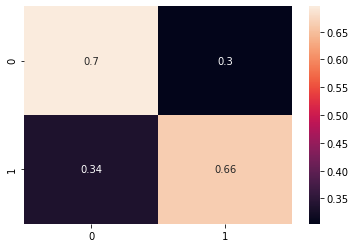

In [15]:
best_models_balanced = {}

for i in checks:

  tmp_clf = make_pipeline(StandardScaler(), SVC(gamma='auto',class_weight='balanced'))
  # tmp_clf.fit(embd_X[i],Y[i])
  
  scores = cross_validate(tmp_clf, embd_X[i], Y[i], scoring=scoring,return_estimator=True,cv=10)
  print("***********{}**********".format(i))
  # print(scores)

  best_model_ndx = np.argmax(scores['test_roc_auc'])
  print
  best_models_balanced[i] = scores['estimator'][best_model_ndx]

  analyse_clf(best_models_balanced[i],i)

# best_clf = best_models_balanced[4]

In [18]:
best_models_balanced
best_clf = best_models_balanced[5]

In [16]:
from collections import Counter

for i in checks:
  print("***********{}**********".format(i))

  counted_vals = Counter(Y[i])
  zero_label_percent = counted_vals[0] / (counted_vals[0] + counted_vals[1])
  one_label_percent = counted_vals[1] / (counted_vals[0] + counted_vals[1])
  print("No-hypernyms",zero_label_percent)
  print("hypernyms",one_label_percent)

***********5**********
No-hypernyms 0.23776944704779757
hypernyms 0.7622305529522024


In [19]:
# We supposed to play with the examples now
embd_X

{5: array([[-9.99297745e-02, -1.38194663e-01, -3.82604309e-01, ...,
          1.36739848e-03,  5.16568059e-04,  5.86926158e-03],
        [-1.91278121e-01,  9.81590918e-02, -2.88661172e-01, ...,
         -1.34676059e-03,  2.33582178e-03,  3.74030421e-03],
        [-2.91336078e-01, -5.57746655e-02,  2.00538822e-01, ...,
         -3.40588089e-02,  1.59480093e-01, -3.04655087e-02],
        ...,
        [-1.31819270e-01, -1.59282474e-01, -3.21405537e-01, ...,
         -2.22872073e-02, -2.42840325e-02,  1.14601283e-02],
        [-4.08741748e-01, -5.97503600e-01,  2.90708986e-01, ...,
          2.38489063e-03, -1.26046241e-03, -1.30332103e-04],
        [-3.66044683e-01,  6.79228099e-01, -9.89701635e-02, ...,
          1.00204148e-03, -7.53739231e-04,  1.45159328e-03]])}

In [21]:
# extract Bad and Good Examples:

TP, FP, TN, FN = [], [], [], []
got_enough_examples = False
predictions = best_clf.predict(embd_X[5])
counter = 0

for w1,w2,pred,true in zip(words[4]['Word1'],words[4]['Word2'],predictions,Y[4]):
  if true == 0:
    if pred == 0:
      TN.append((w1,w2))
    if pred == 1:
      FP.append((w1,w2))
  if true == 1:
    if pred == 0:
      FN.append((w1,w2))
    if pred == 1:
      TP.append((w1,w2))

KeyError: 4